<a href="https://colab.research.google.com/github/Lupoyo/projectNew/blob/main/LLMS_XLNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from cleantext import clean
import re
from transformers import XLNetTokenizer, XLNetForSequenceClassification, TrainingArguments, Trainer, pipeline
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import datasets
import evaluate
import random

ModuleNotFoundError: No module named 'cleantext'

In [ ]:
import pandas as pd
import numpy as np
from cleantext import clean
import re
from transformers import XLNetTokenizer, XLNetForSequenceClassification, TrainingArguments, Trainer, pipeline
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import datasets
import evaluate
import random


In [41]:
import wandb
wandb.init(project="emotion_classification")

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: lupoyo89 (lupoyo89-education-com) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.5 MB/s eta 0:00:00


Preprocess our data

In [12]:
data_train = pd.read_csv('./content/drive/MyDrive/emotion-labels-test.csv')
data_test = pd.read_csv('./content/drive/MyDrive/emotion-labels-train.csv')
data_val = pd.read_csv('./content/drive/MyDrive/emotion-labels-val.csv')
# data should be saved in a folder called 'emotions' which is saved in the same place as your notebook

In [13]:
data_train.head()

,text,label
0,You must be knowing #blithe means (adj.) Happ...,joy
1,Old saying 'A #smile shared is one gained for ...,joy
2,Bridget Jones' Baby was bloody hilarious 😅 #Br...,joy
3,@Elaminova sparkling water makes your life spa...,joy
4,I'm tired of everybody telling me to chill out...,joy


In [14]:
data = pd.concat([data_train, data_test, data_val], ignore_index=True)

In [16]:
data['text_clean'] = data['text'].apply(lambda x: clean(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [17]:
data['text_clean'] = data['text_clean'].apply(lambda x: re.sub('@[^\s]+', '', x))

In [18]:
data.head(20)

,text,label,text_clean
0,You must be knowing #blithe means (adj.) Happ...,joy,must know blith mean adj happi cheer
1,Old saying 'A #smile shared is one gained for ...,joy,old say smile share one gain anoth day yeglif ...
2,Bridget Jones' Baby was bloody hilarious 😅 #Br...,joy,bridget jone babi bloodi hilari 😅 bridgetjones...
3,@Elaminova sparkling water makes your life spa...,joy,elaminova sparkl water make life sparkli
4,I'm tired of everybody telling me to chill out...,joy,im tire everybodi tell chill everyth ok fuck i...
5,#GBBO can cheer me up ☺️,joy,gbbo cheer ☺️
6,"&amp; as much as I hate for a dude to cheat, w...",joy,amp much hate dude cheat women forego pleas ma...
7,@GOT7Official @jrjyp happy birthday jin young!...,joy,gotoffici jrjyp happi birthday jin young princ...
8,@GOT7Official @jrjyp happy birthday jin young!...,joy,gotoffici jrjyp happi birthday jin young princ...
9,The race advances only by the extra achievemen...,joy,race advanc extra achiev individu individu cha...


<Axes: xlabel='label'>

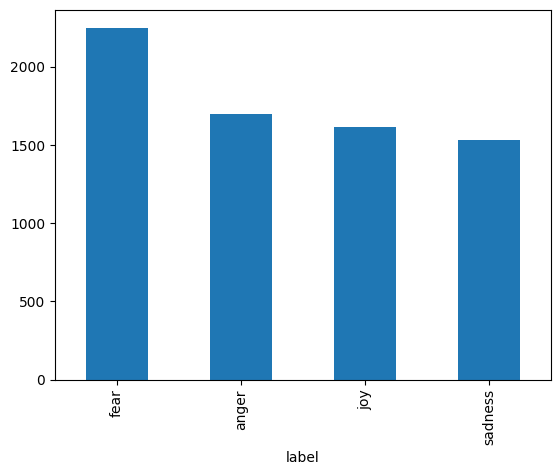

In [19]:
data['label'].value_counts().plot(kind="bar")

In [20]:
g = data.groupby('label')
data = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True)))

/tmp/ipython-input-2135407547.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True)))


<Axes: xlabel='label'>

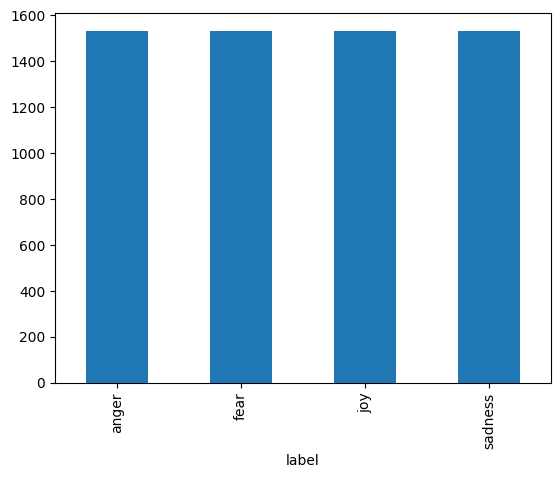

In [21]:
data['label'].value_counts().plot(kind="bar")

In [22]:
data['label_int'] = LabelEncoder().fit_transform(data['label'])
NUM_LABELS = 4
train_split, test_split = train_test_split(data, train_size = 0.8)
train_split, val_split = train_test_split(train_split, train_size = 0.9)
print(len(train_split))
print(len(test_split))
print(len(val_split))

4414
1227
491


In [23]:
train_df = pd.DataFrame({
    "label": train_split.label_int.values,
    "text": train_split.text_clean.values
})

test_df = pd.DataFrame({
    "label": test_split.label_int.values,
    "text": test_split.text_clean.values
})

In [24]:
train_df = datasets.Dataset.from_dict(train_df)
test_df = datasets.Dataset.from_dict(test_df)
dataset_dict = datasets.DatasetDict({"train":train_df, "test":test_df})
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 4414
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 1227
    })
})

Create embeddings

In [25]:
tokenizer = XLNetTokenizer.from_pretrained("xlnet-base-cased")
def tokenize_function(examples):
    return tokenizer(examples["text"], padding = "max_length", max_length = 128, truncation=True)
tokenized_datasets = dataset_dict.map(tokenize_function, batched=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

Map:   0%|          | 0/4414 [00:00<?, ? examples/s]

Map:   0%|          | 0/1227 [00:00<?, ? examples/s]

In [26]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4414
    })
    test: Dataset({
        features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1227
    })
})

In [27]:
print(tokenized_datasets['train']['text'][0])

patriot lamest color rush jersey whole nfl madden hope wear tonight


In [28]:
print(tokenized_datasets['train']['input_ids'][0])

[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 29645, 21128, 639, 1638, 5766, 10331, 856, 17, 180, 722, 368, 6321, 1426, 937, 3134, 4445, 4, 3]


In [29]:
tokenizer.decode(5)

'<pad>'

In [30]:
print(tokenized_datasets['train']['token_type_ids'][0])

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2]


In [31]:
print(tokenized_datasets['train']['attention_mask'][0])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [32]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(100))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(100))

FINAL MODEL

In [33]:
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased',
                                                       num_labels=NUM_LABELS,
                                                       id2label={0: 'anger', 1: 'fear', 2: 'joy', 3: 'sadness'})

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
metric = evaluate.load("accuracy")

In [35]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [36]:
training_args = TrainingArguments(output_dir="test_trainer", eval_strategy="epoch", num_train_epochs=3)

In [37]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics)

In [42]:


trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.431509,0.280000
2,No log,1.443629,0.270000
3,No log,1.425839,0.250000


Epoch,Training Loss,Validation Loss


TrainOutput(global_step=39, training_loss=1.4243980798965845, metrics={'train_runtime': 615.5023, 'train_samples_per_second': 0.487, 'train_steps_per_second': 0.063, 'total_flos': 28488500428800.0, 'train_loss': 1.4243980798965845, 'epoch': 3.0})

Evaluate model

In [43]:
trainer.evaluate()

{'eval_loss': 1.4258389472961426,
 'eval_accuracy': 0.25,
 'eval_runtime': 46.9177,
 'eval_samples_per_second': 2.131,
 'eval_steps_per_second': 0.277,
 'epoch': 3.0}

In [44]:
model.save_pretrained("fine_tuned_model")

In [45]:
fine_tuned_model = XLNetForSequenceClassification.from_pretrained("fine_tuned_model")

In [46]:
clf = pipeline("text-classification", fine_tuned_model, tokenizer=tokenizer)

Device set to use cpu


In [47]:
rand_int = random.randint(0, len(val_split))
print(val_split['text_clean'][rand_int])
answer = clf(val_split['text_clean'][rand_int], top_k=None)
print(answer)

/tmp/ipython-input-3116462782.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(val_split['text_clean'][rand_int])
/tmp/ipython-input-3116462782.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  answer = clf(val_split['text_clean'][rand_int], top_k=None)


get much pussynp panic attack nu uncontrol anxieti ns suicid fantasi ns sad ny yearn death
[{'label': 'joy', 'score': 0.31248757243156433}, {'label': 'fear', 'score': 0.2875789999961853}, {'label': 'anger', 'score': 0.23023030161857605}, {'label': 'sadness', 'score': 0.16970306634902954}]
